<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/dense_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.3

In [2]:
!mkdir work_dir

# DEFINE

In [3]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [182]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import PIL
import cv2
import re

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm
from scipy.stats import shapiro

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [262]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')

# PREPARING

In [263]:
df = pd.concat([train, test])

(array([  73.,  310., 1460., 2195., 2075.,  600., 1091.,  449.,    0.,
         100.]),
 array([14175.44005965, 14175.82369518, 14176.2073307 , 14176.59096623,
        14176.97460175, 14177.35823728, 14177.7418728 , 14178.12550832,
        14178.50914385, 14178.89277937, 14179.2764149 ]),
 <a list of 10 Patch objects>)

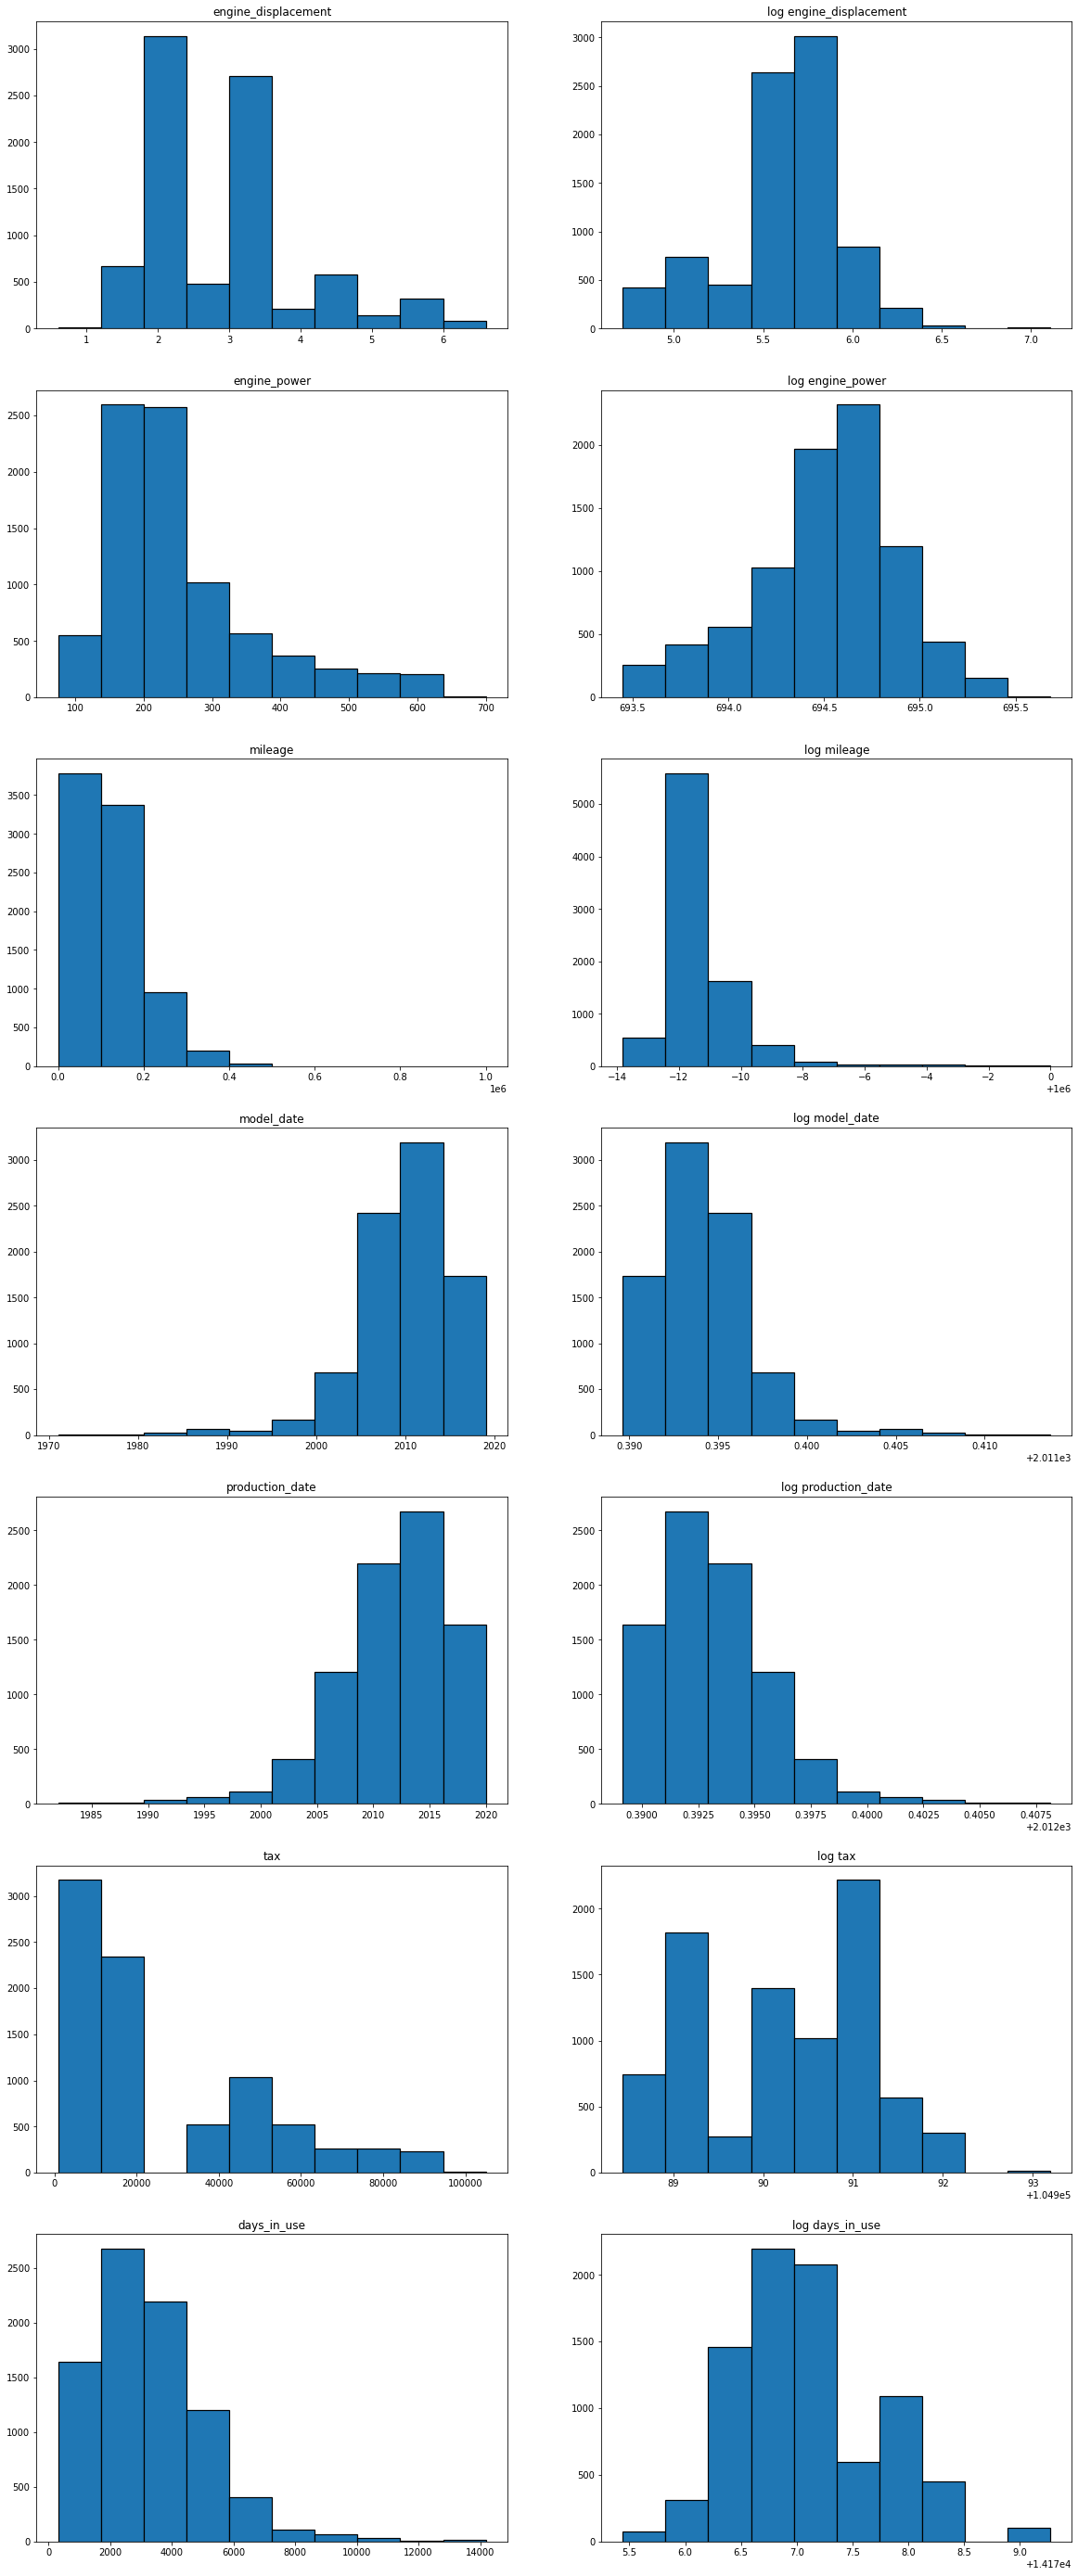

In [276]:
fig, ax = plt.subplots(7,2, figsize=(20,50))

# ####################### engine_displacement ############################
ax[0,0].set_title('engine_displacement')
ax[0,0].hist(df['engine_displacement'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[0,1].set_title('log engine_displacement')
ax[0,1].hist(df['engine_displacement'].max() - np.log(df['engine_displacement']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### engine_power ############################
ax[1,0].set_title('engine_power')
ax[1,0].hist(df['engine_power'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[1,1].set_title('log engine_power')
ax[1,1].hist(df['engine_power'].max() - np.log(df['engine_power']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### mileage ############################
ax[2,0].set_title('mileage')
ax[2,0].hist(df['mileage'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[2,1].set_title('log mileage')
ax[2,1].hist(df['mileage'].max() - np.log(df['mileage']), bins=10, edgecolor='black' ,linewidth=1.2)


# ####################### model_date ############################
ax[3,0].set_title('model_date')
ax[3,0].hist(df['model_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[3,1].set_title('log model_date')
ax[3,1].hist(df['model_date'].max() - np.log(df['model_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### production_date ############################
ax[4,0].set_title('production_date')
ax[4,0].hist(df['production_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[4,1].set_title('log production_date')
ax[4,1].hist(df['production_date'].max() - np.log(df['production_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### tax ############################
ax[5,0].set_title('tax')
ax[5,0].hist(df['tax'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[5,1].set_title('log tax')
ax[5,1].hist(df['tax'].max() - np.log(df['tax']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### days_in_use ############################
ax[6,0].set_title('days_in_use')
ax[6,0].hist(df['days_in_use'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[6,1].set_title('log days_in_use')
ax[6,1].hist(df['days_in_use'].max() - np.log(df['days_in_use']), bins=10, edgecolor='black' ,linewidth=1.2)

In [254]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [255]:
# ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)
# df.mileage = df.mileage.max() - np.log(df.mileage)
df.model_date = df.model_date.max() - np.log(df.model_date)
df.production_date = df.production_date.max() - np.log(df.production_date)
# df.num_of_doors = np.log(df.num_of_doors)
# df.tax = np.log(df.tax)
df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

Модель показывает лучше результат, если признак **num_of_doors** сделать категориальным.

Если взять логорифм перед нормализацией от всех признаков, кроме **mileage**, то модель показывает лучший результат

In [256]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [257]:
df = data_prep(df)
df.shape

(8353, 545)

# SPLIT

In [258]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# MODEL

In [259]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [260]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ######################### Create simple neural network #############################
  model = Sequential()
  model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
  model.add(L.Dropout(0.5))
  model.add(L.Dense(256, activation="relu"))
  model.add(L.Dropout(0.5))
  model.add(L.Dense(1, activation="linear"))

  # ######################### Optimizer ##############################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_1.hdf5')

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.grid()
  plt.show()

  test_predict_nn1 = model.predict(X_test)
  print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history

Опытным путем установил, что лучший результат модель показывает, когда мы используем **Adamax optimizer** с **learning rate 0.1**

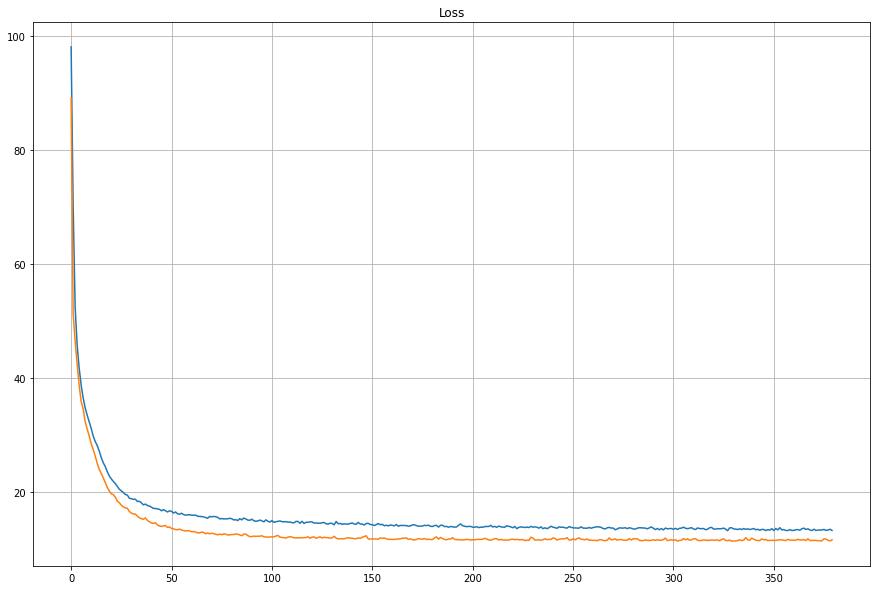

TEST mape: 11.57%


In [261]:
model, checkpoint, earlystop, callbacks_list, history = build_model(LR=0.1, EPOCHS=1000, OPTIMIZER_TYPE='Adamax')

# PREDICT

In [226]:
predict_submission = model.predict(test)

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+'/sub_nn.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,5.854099e+05
1,1096405886,2.540650e+06
2,1100195294,6.553922e+05
3,1099827282,5.095113e+05
4,1100076198,2.777478e+06
5,1090159352,3.201344e+06
6,1098987386,1.601506e+06
7,1098639040,1.614259e+06
8,1099933039,1.077730e+06
9,1099565572,5.126351e+05
